In [2]:
import numpy as np
import matplotlib.pyplot as pyp
import sys
import os
import matplotlib
print sys.path.append(os.environ.get("TAU_ACC_DIR"))
import generate_electric_field_lookup_tables as efieldlut
%matplotlib inline

None
/Users/wissels/Dropbox/MountainTop/harms_sims/npz_files/


In [3]:
pastel_colors = ['#FF6666','#FFCC66','#CCFF66','#66FF66','#66FFCC','#66FFFF','#66CCFF','#6666FF','#CC66FF','#FF66FF','#FF6FCF']
bright_colors = ['#FF0000','#FF8000','#FFFF00','#80FF00','#00FF00','#00FF80','#00FFFF','#0080FF','#0000FF','#8000FF','#FF00FF']
bright_colors2 = bright_colors = ['#FF0000','#FF8000','#80FF00','#00FF80','#0080FF','#0000FF','#8000FF','#FF00FF','#FF0080']
pyp.rcParams['font.size']=12
pyp.rcParams['legend.labelspacing'] = 0.1
cmap = matplotlib.cm.get_cmap('inferno')

In [4]:
# read CSV pulse files and calculate the frequency-domain peak electric field
altitude=37
zenith_list, psi_list, f_Lo_list, epeak_array = efieldlut.construct_epeak_array(altitude)

In [5]:
# read the interpolator file
EFIELD_LUT_filename = os.environ['TAU_ACC_ZHAIRES_DIR']\
		       +'/interpolator_efields_%dkm.npz'%altitude
efield_interpolator_list = efieldlut.load_efield_interpolator(EFIELD_LUT_filename)

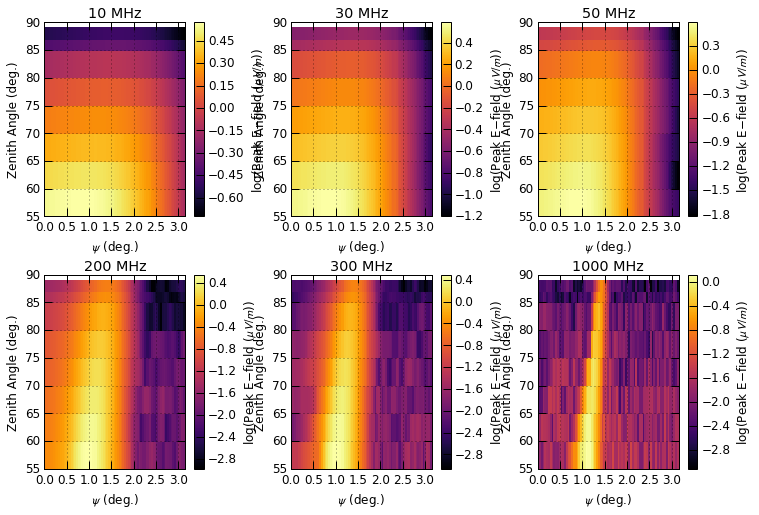

In [6]:
# compare the 2d histograms of epeak vs. zenith vs. psi
# to the interpolated plots
choose_start_freq = [10., 30., 50., 200., 300., 1000.]
efieldlut.plot_epeak_zenith_psi(altitude, epeak_array, 
                                zenith_list, psi_list, choose_start_freq, log=True)


/Users/wissels/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:867: RuntimeWarning: invalid value encountered in less_equal
  return umath.less_equal(x, self.critical_value)
generate_electric_field_lookup_tables.py:429: RuntimeWarning: divide by zero encountered in log10
  Hmasked = np.log10(Hmasked)


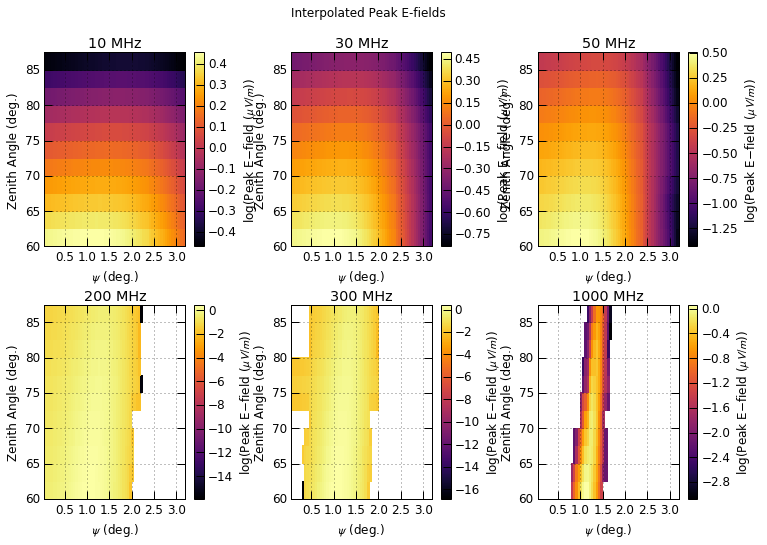

In [7]:
#choose_start_freq = [15., 35., 55., 205., 305., 1005.]
choose_start_freq = [10., 30., 50., 200., 300., 1000.]
efieldlut.plot_interp_zenith_psi(altitude, efield_interpolator_list, choose_start_freq, log=True)

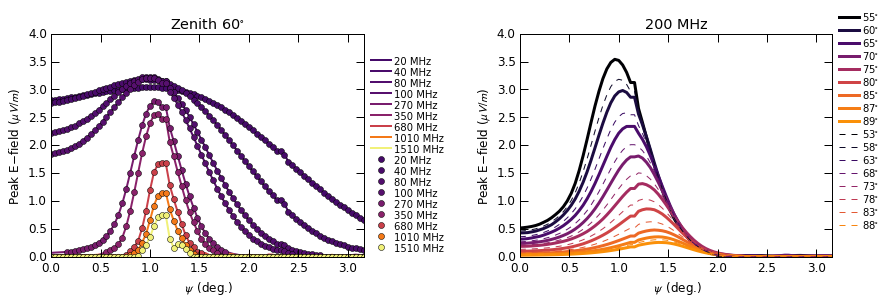

In [8]:
choose_ze = 60
choose_f_Lo = 200
efieldlut.compare_1d_plots( altitude, epeak_array, efield_interpolator_list, 
                           zenith_list, psi_list, f_Lo_list, choose_ze, choose_f_Lo, False)